In [1]:
#!pip install --user -U pip

In [2]:
#!pip install --user umap-learn

In [3]:
#!pip install --user -U seaborn

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from umap import UMAP

In [31]:
# old:
# chr5:3,566,700-3,567,700
# http://ucsc.gao-lab.org/cgi-bin/hgTracks?db=tair10&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=Chr5%3A3566700%2D3567700&hgsid=164617_9lNIGAWPpARSj47ipyGVNh4OanwR


embedding = np.load("example_embedding_1M.npy")
embedding.shape

(1000000, 512)

In [59]:
latent = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=40))
]).fit_transform(embedding)
latent.shape

(1000000, 40)

(1000, 40)


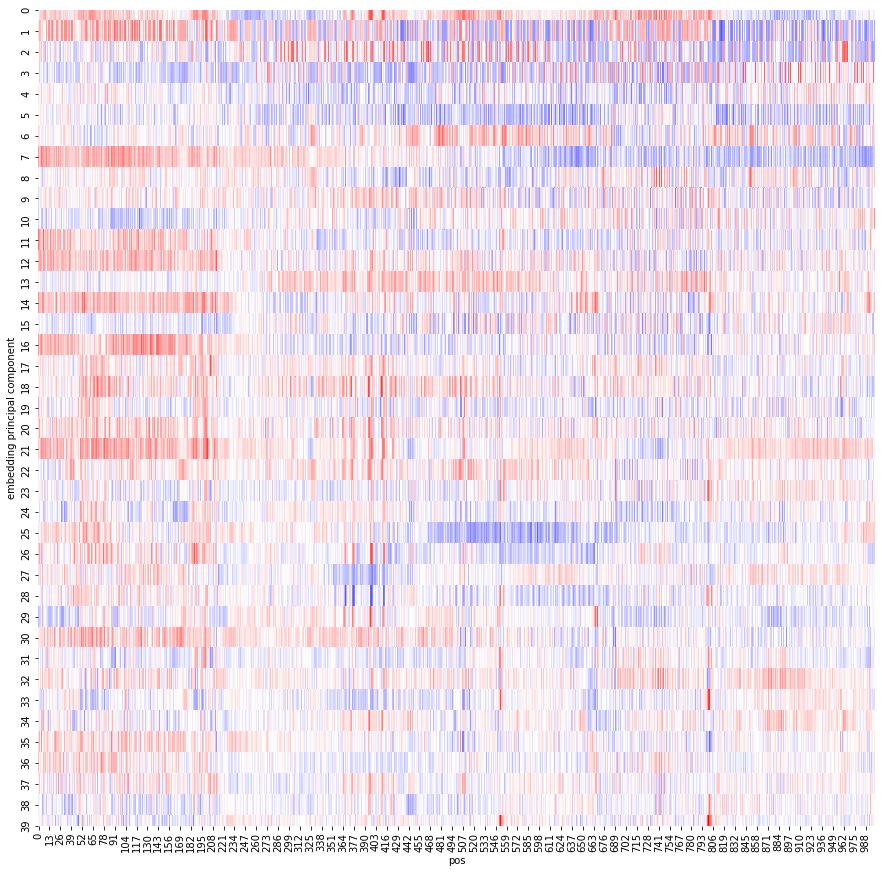

In [65]:
window_size = 1000000
center = 3566700

# original
start = 3566700
end = 3567700

# start codon visible here:
#start = 3567353
#end = 3567402

# there might be alternative splicing here, could find a better example
#start = 3568831
#end = 3569781

# example TFBS from FunTFBS
#start = 3561983
#end = 3562056

# gene on the negative strand. there's another thing interesting here, to inspect
#start = 3557970
#end = 3558946

# TODO: find an enhancer example

# TODO: find tranposon example

# would be nice to find an example of a certain protein domain or something interesting about a protein

redo_pca = False

if redo_pca:
    latent_zoom = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=10))]).fit_transform(embedding[window_size//2+start-center:window_size//2+end-center])
else:
    latent_zoom = latent[window_size//2+start-center:window_size//2+end-center]
print(latent_zoom.shape)

df2 = pd.DataFrame(data=latent_zoom.T)
plt.figure(figsize=(15, 15))
sns.heatmap(
    data=df2,
    cmap="bwr",
    center=0,
    square=False,
    yticklabels=1,
    cbar=False,
)
plt.xlabel("pos")
plt.ylabel("embedding principal component");

In [83]:
for pc in range(1, 21):
    df_bedgraph = pd.DataFrame({
        "chromosome": ["chr5" for _ in range(len(latent_zoom))],
        "start": np.arange(start, end),
        "end": np.arange(start+1, end+1),
        "values": latent_zoom[:, pc-1],
    })
    print(df_bedgraph)

    with open(f'example_bedgraph_PC{pc}.txt', 'a') as file:
        file.write(f'track type=bedGraph name="PC{pc}" description="PC{pc}" visibility=full color=255,0,0 altColor=0,0,255 maxHeightPixels=32\n')
        df_bedgraph.to_csv(file, sep="\t", header=False, index=False)

    chromosome    start      end    values
0         chr5  3566700  3566701  0.844862
1         chr5  3566701  3566702  2.205046
2         chr5  3566702  3566703  1.499352
3         chr5  3566703  3566704  2.386457
4         chr5  3566704  3566705  2.151994
..         ...      ...      ...       ...
995       chr5  3567695  3567696 -2.108944
996       chr5  3567696  3567697 -0.441135
997       chr5  3567697  3567698  0.304019
998       chr5  3567698  3567699 -1.011496
999       chr5  3567699  3567700 -0.534138

[1000 rows x 4 columns]
    chromosome    start      end    values
0         chr5  3566700  3566701  1.109633
1         chr5  3566701  3566702  4.197469
2         chr5  3566702  3566703  3.764820
3         chr5  3566703  3566704  3.462405
4         chr5  3566704  3566705  1.246260
..         ...      ...      ...       ...
995       chr5  3567695  3567696  0.646177
996       chr5  3567696  3567697 -3.094267
997       chr5  3567697  3567698 -4.029203
998       chr5  3567698  3567

In [53]:
cluster = KMeans(n_clusters=10).fit_predict(latent)
cluster.shape

(1000000,)

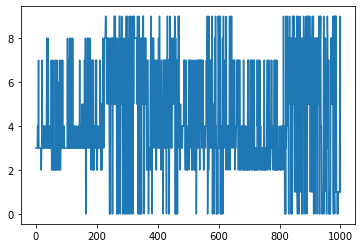

In [55]:
cluster_zoom = cluster[window_size//2+start-center:window_size//2+end-center]
plt.plot(cluster_zoom)

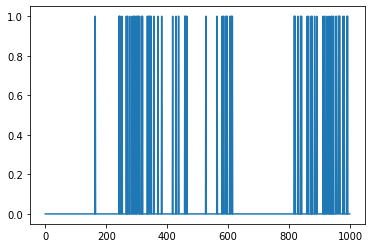

In [64]:
plt.plot(cluster_zoom==0)

In [71]:
from sklearn.ensemble import IsolationForest
outliers = IsolationForest().fit_predict(latent)
outliers.shape

(1000000,)

In [73]:
(outliers==-1).sum()

29105

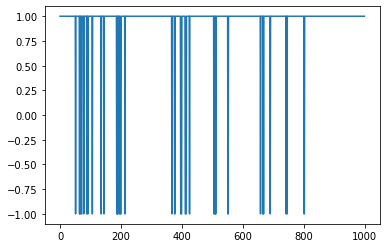

In [74]:
outliers_zoom = outliers[window_size//2+start-center:window_size//2+end-center]
plt.plot(outliers_zoom)

In [6]:
pca = latent[:, :2]
pca.shape

(1000, 2)

In [8]:
umap = UMAP(n_components=2).fit_transform(latent)
umap.shape

(1000, 2)

In [10]:
df = pd.DataFrame(dict(
    pos=np.arange(len(pca)),
    PC1=pca[:, 0],
    PC2=pca[:, 1],
    UMAP1=umap[:, 0],
    UMAP2=umap[:, 1],
    cluster=cluster,
))
df

,pos,PC1,PC2,UMAP1,UMAP2,cluster
0,0,50.100275,47.033956,-1.997581,-1.499112,0
1,1,-15.581747,58.113229,3.939169,1.259042,9
2,2,42.981641,48.829378,-1.950673,-1.527698,0
3,3,57.940017,44.216418,-1.919837,-1.565005,0
4,4,54.583325,44.338956,-2.005317,-1.508748,0
...,...,...,...,...,...,...
995,995,-54.021989,4.442022,15.721426,8.985989,5
996,996,37.537841,-38.226426,3.382890,-7.703012,8
997,997,-60.360278,-4.954267,15.443886,9.104552,5
998,998,-57.236034,-2.336900,15.399879,9.095137,5


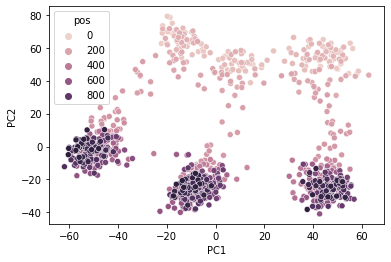

In [11]:
sns.scatterplot(data=df, x="PC1", y="PC2", hue="pos")

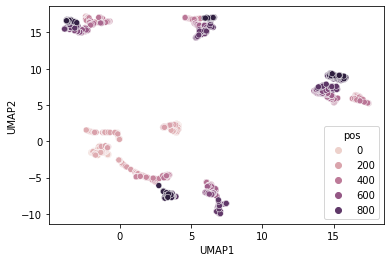

In [12]:
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="pos")

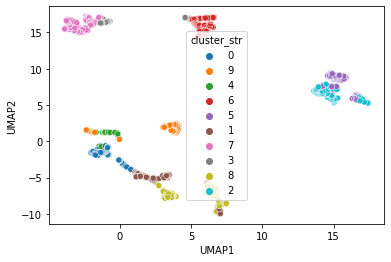

In [13]:
df["cluster_str"] = df.cluster.astype(str)
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="cluster_str")

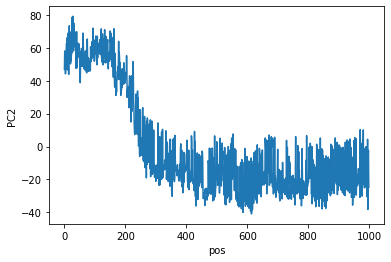

In [14]:
sns.lineplot(data=df, x="pos", y="PC2")

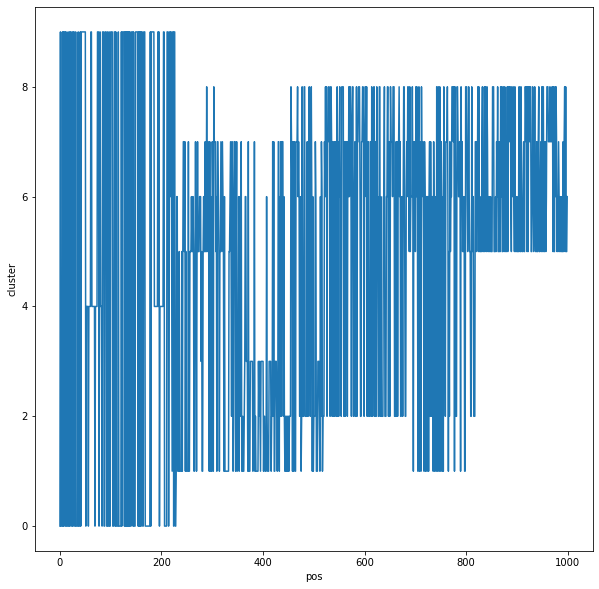

In [15]:
plt.figure(figsize=(10, 10))
sns.lineplot(data=df, x="pos", y="cluster")

In [38]:
seq = "ATAAACATATCATAAATAAGATCAATATTAATAAAATAAATAGTTTTTTTTACGGGACGGATTGGCGGGACGAGTTTAGCAGGACGTAACTTAATAACAATTGTAAACTATAAAATAAAAATATTTTATAGATAGATACAATTTGCAAACTTTTATATATACTAACTTAAAAAAAAAATATTGTCCCCTGCGGTATAAGACGGGTTAAAAATCTAGTTGTTATTATTAAAGGAAATAAAATATCCTCATAAAACAATTTGTTGTAATCTATCTTTGGGCTAATGTTCTTATCCTACAAGACGAACCCTGACCGTATTCGTCGTAGAAAAAAAATTGCTTCGATCCCATCATTGAGTTCAATAATCGGCGCACAAAGGCCGATTCATAAAAACTCTAGGCCCATTAAAGTAAAGCCCATTCTCAACCCTATCCAGTCTCCCTGTATATATATATTTACGACACCAACCCAGCGTTGATATTTAATTTTCTTCAGTCAGAGATTTCGAAACCCTAGTCGATTTCGAGATCCAACTAACTCTGCTCCTTATCTCAGGTAAAATTCTCGCTCGAGAACTCAATTGCTTATCCAAAGTTCCAACTGAAGATGCTTTCCTACTGAATCTTAGGTTAATGTTTTGGATTTGGAATCTTACCCGAAATTTCTCTGCAGCTTGTTGAATTTGCGAAGTATGGGAGACGCTAGAGACAACGAAGCCTACGAGGAGGAGCTCTTGGACTATGAAGAAGAAGACGAGAAGGTCCCAGATTCTGGAAACAAAGTTAACGGCGAAGCTGTGAAAAAGTGAGTTTTATGGTTTCCTCGATATGTTTCATGTATACTACTGTGTGTTTAAATTTGTCGATTCTTAGATTACTACTTGATAACAAGTAGCAGTATGTGTTTAATTAGTTGCTTAACATATAACAATTGACTGAGTTCTTCATTGCTATAATTCCTGAAACCCACCCAATATTAGACTGTCGTGTGTTTCTCATATTG"

In [41]:
seq[:30]

'ATAAACATATCATAAATAAGATCAATATTA'